In [201]:
import os
import os.path as path
import math
import skimage.io as io
import numpy as np
import scipy as sp
import skimage
from skimage import color
from skimage import util
import skimage.filters as filters
import matplotlib.pyplot as plt
import scipy.sparse as sparse
import scipy.linalg as linalg
from scipy import signal
from scipy.interpolate import interp1d
from skimage import color
import cv2
from sksparse.cholmod import cholesky,cholesky_AAt
from scipy.interpolate import RegularGridInterpolator
import pandas as pd
from skimage.metrics import structural_similarity as ssim
from scipy.ndimage import gaussian_filter

from task4_grad_domain import img2grad_field, reconstruct_grad_field
#https://github.com/yig/PySPQR
import sparseqr

#pip install git+https://github.com/dvolgyes/TMQI
import imageio
imageio.plugins.freeimage.download()
from TMQI import TMQI

# Section A: Image Processing Operators

### Gradient Enhancement Operators

In [2]:
def optGrad(im):
    im = skimage.img_as_float(im)

    im_gray = color.rgb2gray(im)

    G = img2grad_field(im_gray)

    x_in = 0.425
    m = 1.458

    x = np.arange(-2.0, 2.0, 0.1)
    y = m*x
    f1 = interp1d(x, y)

    m2 = (m*x_in -1)/(x_in - 1)
    y2 = m2*x + (1-m2)
    f2 = interp1d(x, y2)

    G_enhanced = np.zeros(G.shape)
    G_enhanced = np.where(G < x_in, f1(G), f2(G))

    Gm = np.sqrt(np.sum(G_enhanced*G_enhanced, axis=2))
    w = 1/(Gm + 0.0001)     # to avoid pinching artefacts
    imr = reconstruct_grad_field(G_enhanced,w,im_gray[0,0], im_gray, "cholesky").clip(0,1)
    imr_col = im.copy()
    c = imr/(im_gray+ 0.0001) # 0.0001 to avoid diversion by 0
    for i in range(0,3):
        imr_col[:,:,i] = im[:,:,i]*c
    
    result = np.round(imr_col.clip(0,1)*255).astype('uint8')
    
    return result

### Tone Mapping

In [71]:
def tm_index(hdr_img,ldr_img):
    r1 = hdr_img
    r2 = ldr_img
    a =TMQI.TMQI()(np.nan_to_num(r1,0),np.nan_to_num(r2,0))
    #Quality Assessment Model, StructuralFidelity, Statistical Naturalness
    print(
        f"TMQI \n Q: {np.round(a[0],8)},\
        S: {np.round(a[1],8)},\
        N: {a[2]}\n")
    return a[0],a[1],a[2]
    
def prepareHDRimg(lowr, tm_td = False,tm_m = False, tm_r = False, tm_tdu = False):
    # Merge exposures to HDR image
    filename = "./images/hdr-data/Arches_E_PineTree_3k.hdr"
    hdr = imageio.imread(filename,format='HDR')
    
    scale_fac = 8 if lowr else 2
    sz = (int(hdr.shape[1]/scale_fac),int(hdr.shape[0]/scale_fac))
    hdr = cv2.resize(hdr, sz)
    
    if (tm_d):
        tonemap1 = cv2.createTonemapDrago(gamma=2.2, saturation=1)
        ldr = tonemap1.process(hdr.copy())
    elif (tm_m):
        tonemap1 = cv2.createTonemapMantiuk(gamma=2.2, saturation=0.9, scale=0.7)
        ldr = tonemap1.process(hdr.copy())
    elif (tm_r):
        tonemap1 = cv2.createTonemapReinhard(gamma=2.2, intensity=0, light_adapt=0.8, color_adapt=0)
        ldr = tonemap1.process(hdr.copy())
    else:
        tonemap1 = cv2.createTonemapDurand(gamma=2.2)
        ldr = tonemap1.process(hdr.copy())

    r1 = np.nan_to_num(hdr,0)
    r2 = np.nan_to_num(ldr,0)
    index = []*3
    index = tm_index(r1,r2) 
    
    return np.round(r1*255).astype('uint8'),np.round(r2.clip(0,1)*255).astype('uint8'), index

# Section B: Bilateral Guided Upsampling Model

In [4]:
def getWeightMatrix(grid_size, input_img, arg_edge_img):
    num_grid_cells = np.prod(grid_size)
    grid_width = grid_size[0]
    grid_height = grid_size[1]
    grid_depth = grid_size[2]
    grid_affine_input_size = grid_size[3]
    grid_affine_output_size = grid_size[4]
    img_width = input_img.shape[1]#192
    img_height = input_img.shape[0]#320
    num_pixels = img_width*img_height
    edge_img = arg_edge_img

    pixel_x = np.array(range(img_width))
    pixel_y = np.array(range(img_height))

    #convert pixel to bg coordinate
    #+0.5 as pixels are considered to be at the center of their little square
    bg_coordx = ((pixel_x + 0.5)/(img_width)) * (grid_width-1)
    bg_coordy = ((pixel_y + 0.5)/(img_height)) * (grid_height-1)
    bg_coordz = edge_img * (grid_depth-1)

    #floor func quantize the floating point array into integer
    bg_int_x = np.floor(bg_coordx)
    bg_int_y = np.floor(bg_coordy)
    bg_int_z = np.floor(bg_coordz)

    #concat 1D array into 2D(which has the same size of the image)
    bg_int_x_img = np.tile(np.floor(bg_coordx),(img_height, 1))
    bg_int_y_img = np.repeat((np.floor(bg_coordy)).reshape(img_height,1),img_width,axis = 1)
    bg_int_z_img = bg_int_z

    #compute dxdydz: distance of each point from the integeral bilateral grid coordinate
    dx = np.tile((bg_coordx - bg_int_x),(img_height, 1))
    dy = np.repeat((bg_coordy - bg_int_y).reshape(img_height,1),img_width,axis = 1)
    dz = bg_coordz - bg_int_z
    
    # Each weight_{x}{y}{z} is an image (height x width) ??
    w_000_temp = np.multiply ((1 - dx),(1 - dy))
    w_000 = np.multiply(w_000_temp,(1 - dz)).reshape(num_pixels)
    
    w_100_temp = np.multiply ((    dx),(1 - dy))
    w_100 = np.multiply(w_100_temp, (1 - dz)).reshape(num_pixels)
    
    w_010_temp = np.multiply ((1 - dx),(    dy))
    w_010 = np.multiply(w_010_temp,(1 - dz)).reshape(num_pixels)
    
    w_110_temp = np.multiply ((    dx),(    dy))
    w_110 = np.multiply(w_110_temp,(1 - dz)).reshape(num_pixels)
    
    w_001_temp = np.multiply ((1 - dx),(1 - dy))
    w_001 = np.multiply(w_001_temp,(    dz)).reshape(num_pixels)
    
    w_101_temp = np.multiply ((    dx),(1 - dy))
    w_101 = np.multiply(w_101_temp,(    dz)).reshape(num_pixels)
    
    w_011_temp = np.multiply ((1 - dx),(    dy))
    w_011 = np.multiply(w_011_temp,(    dz)).reshape(num_pixels)
    
    w_111_temp = np.multiply ((    dx),(    dy))
    w_111 = np.multiply(w_111_temp,(    dz)).reshape(num_pixels)
    
    w_i = np.tile(range(num_pixels),(8, 1)).reshape(num_pixels*8)
    w_j = np.array(range(num_pixels*8)).reshape(num_pixels*8) #sparse matrix y coordinate
    w_val = np.squeeze(np.concatenate([w_000,w_100,w_010,w_110,w_001,w_101,w_011,w_111]))
    w_m = num_pixels
    w_n = num_pixels*8
    
    weight = sparse.csr_matrix((w_val,(w_i,w_j)),
                 shape = (w_m,w_n))
    
    total_weight = sparse.block_diag((weight,weight,weight,weight,weight,weight,weight,weight,weight,weight,weight,weight))
    
    return total_weight

In [5]:
def getSliceMatrix(grid_size, input_img, arg_edge_img):
    num_grid_cells = np.prod(grid_size)
    grid_width = grid_size[0]
    grid_height = grid_size[1]
    grid_depth = grid_size[2]
    grid_affine_input_size = grid_size[3]
    grid_affine_output_size = grid_size[4]
    img_width = input_img.shape[1]#192
    img_height = input_img.shape[0]#320
    num_pixels = img_width*img_height
    edge_img = arg_edge_img

    pixel_x = np.array(range(img_width))
    pixel_y = np.array(range(img_height))

    #convert pixel to bg coordinate
    #+0.5 as pixels are considered to be at the center of their little square
    bg_coordx = ((pixel_x + 0.5)/(img_width)) * (grid_width-1)
    bg_coordy = ((pixel_y + 0.5)/(img_height)) * (grid_height-1)
    bg_coordz = edge_img * (grid_depth-1)

    #floor func quantize the floating point array into integer
    bg_int_x = np.floor(bg_coordx)
    bg_int_y = np.floor(bg_coordy)
    bg_int_z = np.floor(bg_coordz)

    #concat 1D array into 2D(which has the same size of the image)
    bg_int_x_img = np.tile(np.floor(bg_coordx),(img_height, 1))
    bg_int_y_img = np.repeat((np.floor(bg_coordy)).reshape(img_height,1),img_width,axis = 1)
    bg_int_z_img = bg_int_z
    
    st_indice = np.array(range(num_pixels*8))
    st_bg_x = np.concatenate(((bg_int_x_img + 0), (bg_int_x_img + 1),(bg_int_x_img + 0),(bg_int_x_img + 1), (bg_int_x_img + 0),(bg_int_x_img + 1),(bg_int_x_img + 0), (bg_int_x_img + 1))).reshape(num_pixels*8,1)
    st_bg_y = np.concatenate(((bg_int_y_img + 0), (bg_int_y_img + 0),(bg_int_y_img + 1),(bg_int_y_img + 1), (bg_int_y_img + 0),(bg_int_y_img + 0),(bg_int_y_img + 1), (bg_int_y_img + 1))).reshape(num_pixels*8,1)
    st_bg_z = np.concatenate(((bg_int_z_img + 0), (bg_int_z_img + 0),(bg_int_z_img + 0),(bg_int_z_img + 0), (bg_int_z_img + 1),(bg_int_z_img + 1),(bg_int_z_img + 1), (bg_int_z_img + 1))).reshape(num_pixels*8,1)
    
    #prune away indices that are out of bound of the grid cell
    indices = (st_bg_x >= 0) & (st_bg_x < grid_width) & (st_bg_y >= 0) & (st_bg_y < grid_height)& (st_bg_z >= 0) & (st_bg_z < grid_depth)
    indices = np.squeeze(indices)
    st_ii = st_indice[indices]
    st_bg_xx = st_bg_x[indices].astype(int)
    st_bg_yy = st_bg_y[indices].astype(int)
    st_bg_zz = st_bg_z[indices].astype(int)
    
        
    st_list = []
    for j in range(grid_affine_input_size):
        for i in range(grid_affine_output_size):
            st_bg_u = j * np.ones((num_pixels*8, 1))
            st_bg_v = i * np.ones((num_pixels*8, 1))
            st_s = np.ones((num_pixels*8, 1))

            
            st_bg_uu = st_bg_u[indices].astype(int)
            st_bg_vv = st_bg_v[indices].astype(int)
            
            st_val = st_s[indices].astype(int)#all ones
            
            st_jj_dim = [grid_width, grid_height, grid_depth, grid_affine_input_size, grid_affine_output_size]
            st_jj = np.ravel_multi_index([st_bg_xx, st_bg_yy, st_bg_zz, st_bg_uu, st_bg_vv], dims=st_jj_dim)
            
            
            st_val = np.squeeze(st_val)
            st_ii = np.squeeze(st_ii)
            st_jj = np.squeeze(st_jj)
            
            st_m = 8 * num_pixels
            st_n = num_grid_cells
            st = sparse.csr_matrix((st_val,(st_ii,st_jj)),shape = (st_m,st_n))

            st_list.append(st)
            
    slice_matrix = sparse.vstack(st_list)

    #a matrix that specify where the data term of the low resolution input is add
    return slice_matrix

In [6]:
def getOrganisedInputImg(input_img, num_of_output_channels):

    img_width = input_img.shape[1]#192
    img_height = input_img.shape[0]#320
    num_pixels = img_width*img_height
    num_of_output_channels = 3
    prepare_input = []
    for k in range(3):
        plane = input_img[:,:,k]
        plane_flat = plane.flatten()
        plane_flat = np.tile(plane_flat,num_of_output_channels) #repeat (number of output channel) times
        color_channel = sparse.diags(plane_flat)
        prepare_input.append(color_channel)

    #add affine dimensions, for offset in linear model
    empty_channel = sparse.diags(np.ones(num_pixels*num_of_output_channels))
    prepare_input.append(empty_channel)

    prepared_input = sparse.hstack(prepare_input)
    return prepared_input

In [7]:
def build_Dx_Matrix(grid_size):
    m = grid_size[0] * (grid_size[1] - 1) #2
    n = grid_size[0] * grid_size[1] #4
    e = np.ones(m+(n-m)+1)
    d_dx = sparse.spdiags([-e, e], [0, grid_size[1]-1], m, n)
    
    d_dx_list = []
    for v in range(grid_size[4]*grid_size[3]*grid_size[2]):
        d_dx_list.append(d_dx)
    A = sparse.block_diag(d_dx_list)
    return A

def build_Dy_Matrix(grid_size):
    ny = grid_size[0]
    e = np.ones(ny)
    d_dy = sparse.spdiags([-e, e], [0, 1], (ny-1), ny)
    
    d_dy_list = []
    for v in range(grid_size[4]*grid_size[3]*grid_size[2]*grid_size[1]):
        d_dy_list.append(d_dy)    
    A = sparse.block_diag(d_dy_list)
    return A

def build_Dz_Matrix(grid_size):
    m = grid_size[0] * grid_size[1] * (grid_size[2] - 1)
    n = grid_size[0] * grid_size[1] * grid_size[2]
    e = np.ones(m+(n-m))
    d_dz = sparse.spdiags([-e, e], [0, grid_size[0]*grid_size[1]], m, n)
    
    d_dz_list = []
    for v in range(grid_size[4]*grid_size[3]):
        d_dz_list.append(d_dz)
    A = sparse.block_diag(d_dz_list)
    return A

def formDxDyDz(input_image, grid_size):
    input_width = input_image.shape[1]
    input_height = input_image.shape[0]

    grid_width = grid_size[0]
    grid_height = grid_size[1]
    grid_depth = grid_size[2]
    affine_output_size = grid_size[4]
    affine_input_size = grid_size[3]
    bin_size_x = input_width / grid_width;
    bin_size_y = input_height / grid_height;
    bin_size_z = 1 / grid_depth;

    num_deriv_y_rows = (grid_height - 1) * grid_width * grid_depth * affine_output_size * affine_input_size
    num_deriv_x_rows = grid_height * (grid_width - 1) * grid_depth * affine_output_size * affine_input_size

    DEFAULT_LAMBDA_SPATIAL = 1;
    lambda_spatial = DEFAULT_LAMBDA_SPATIAL
    DEFAULT_FIRST_DERIVATIVE_LAMBDA_Z = 4e-8
    lambda_z = DEFAULT_FIRST_DERIVATIVE_LAMBDA_Z

    A_deriv_y = (bin_size_x * bin_size_z / bin_size_y) * lambda_spatial * build_Dy_Matrix(grid_size)
    A_deriv_x = (bin_size_y * bin_size_z / bin_size_x) * lambda_spatial * build_Dx_Matrix(grid_size)
    A_intensity = (bin_size_x * bin_size_y / bin_size_z) * lambda_z * build_Dz_Matrix(grid_size)

    b_deriv_y = np.zeros((num_deriv_y_rows,1));
    b_deriv_x = np.zeros((num_deriv_x_rows,1));
    value = lambda_z * 0
    # b_intensity = value * np.ones((A_intensity.shape));
    sz = A_intensity.shape[0]
    b_intensity = sparse.csc_matrix((sz,1))
    return A_deriv_y,A_deriv_x,A_intensity,b_deriv_y,b_deriv_x,b_intensity

In [8]:
def apply_Affine_Model_to_HighR_Input(input_img, edge_img, grid_size, gamma1, nearest):
    grid_width = grid_size[0]
    grid_height = grid_size[1]
    grid_depth = grid_size[2]
    grid_affine_input_size = grid_size[3]
    grid_affine_output_size = grid_size[4]
    img_width = input_img.shape[1]#192
    img_height = input_img.shape[0]#320
    num_pixels = img_width*img_height

    # meshgrid inputs and outputs 
    [x,y] = np.meshgrid(range(img_width),range(img_height))

    # Downsample x and y to grid space
    bg_coord_x = ((x + 0.5) * (grid_width-1) / (img_width))
    bg_coord_y = ((y + 0.5) * (grid_height-1) / (img_height))
    bg_coord_z = edge_img * (grid_depth-1)

    bg_coord_x = np.clip(bg_coord_x, 0, grid_width)
    bg_coord_y = np.clip(bg_coord_y, 0, grid_height)
    bg_coord_z = np.clip(bg_coord_z, 0, grid_depth)

    points = np.array(list(zip(bg_coord_x.flatten(),bg_coord_y.flatten(),bg_coord_z.flatten())))

    
    #interp
    xx = np.linspace(0, (grid_width-1), grid_width)
    yy = np.linspace(0, (grid_height-1), grid_height)
    zz = np.linspace(0, (grid_depth-1), grid_depth)

    affine_model = np.zeros([grid_affine_output_size, grid_affine_input_size, img_height,img_width]);


    for j in range (grid_affine_input_size):
        for i in range (grid_affine_output_size):
            if nearest:
                fn = RegularGridInterpolator((xx,yy,zz), gamma1[:,:,:,j,i], method='nearest')
            else:
                fn = RegularGridInterpolator((xx,yy,zz), gamma1[:,:,:,j,i],  method='linear')
            
            affine_model[i,j] = fn(points).reshape((img_height,img_width))
    
    return affine_model

In [9]:
def getFinalOutput(affine_model, grid_size, highr_input_image):
    # transform high resolution input
    # add ones as the forth layer
    grid_affine_input_size = grid_size[3]
    one = np.ones((highr_input_image[:,:,0].shape[0],highr_input_image[:,:,0].shape[1]))
    c1 = highr_input_image[:,:,0]
    c2 = highr_input_image[:,:,1]
    c3 = highr_input_image[:,:,2]
    transformed_input = np.stack((c1,c2,c3,one))
    
    channel_data =[]
    output_r = 0
    for color_channel in range(3):
        output = 0
        for i in range(grid_affine_input_size):
            img = transformed_input[i,:,:].astype('float')
            output += np.multiply(affine_model[color_channel,i,:,:],img)
        
        output_per_channel = output.clip(1,255).astype('uint8')
        channel_data.append(output_per_channel)
    
    final_output = np.array(list(zip(channel_data[0].flatten(),channel_data[1].flatten(),channel_data[2].flatten()))).reshape(highr_input_image.shape)
    return final_output

In [10]:
def psnr(img1, img2):
    mse = np.mean( (img1 - img2) ** 2 )
    if mse <= 0:
        return 100
    return 20 * math.log10(255.0 / math.sqrt(mse))

In [122]:
def wrapper(
    lowr_input_image, highr_input_image, operator, 
    lowr_out = None , highr_out = None , opt=True, 
    gaussian = False, nearest=False, grid_size = [20,15,10,4,3]):
    
    #Prepare the IO pairs and ground truth
    if opt:
        highr_output_image = operator(highr_input_image)
        lowr_output_image = operator(lowr_input_image)
    else:
        highr_output_image = highr_out
        lowr_output_image = lowr_out
        
    highr_input_edge_image  = cv2.cvtColor(highr_input_image, cv2.COLOR_BGR2GRAY)
    highr_input_edge_image  = cv2.normalize(highr_input_edge_image,highr_input_edge_image , 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_64F)
    lowr_input_edge_image  = cv2.cvtColor(lowr_input_image, cv2.COLOR_BGR2GRAY)
    lowr_input_edge_image  = cv2.normalize(lowr_input_edge_image,lowr_input_edge_image , 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_64F)
    if gaussian:
        lowr_input_edge_image = gaussian_filter(lowr_input_edge_image, sigma=0.5, mode='nearest')
        
    
    weight_matrix = getWeightMatrix(grid_size,lowr_input_image,lowr_input_edge_image)
    slice_matrix = getSliceMatrix(grid_size,lowr_input_image,lowr_input_edge_image)
    organised_input_img = getOrganisedInputImg(lowr_input_image, grid_size[-1])
    
    #Prepare b_data
    output_weight = np.ones(lowr_output_image.shape)
    sqrt_w = np.sqrt(output_weight.flatten())
    c1 = lowr_output_image[:,:,0].flatten()
    c2 = lowr_output_image[:,:,1].flatten()
    c3 = lowr_output_image[:,:,2].flatten()
    b_data = np.hstack((c1,c2,c3))
    b_data = np.multiply(b_data,sqrt_w)
    
    #Prepare a_data
    output_weight_diag_matrix = sparse.diags(sqrt_w)
    A_data = output_weight_diag_matrix * organised_input_img * weight_matrix * slice_matrix
    
    #Smoothness Term
    [A_deriv_y,A_deriv_x,A_intensity,b_deriv_y,b_deriv_x,b_intensity] = formDxDyDz(lowr_input_image, grid_size)
    b_data = b_data.reshape((b_data.shape[0],1))
    
    #Concat A_data, b_data with smoothness terms
    A = sparse.vstack([A_data,A_deriv_x,A_deriv_y,A_intensity])
    b = sparse.vstack([b_data,b_deriv_x,b_deriv_y,b_intensity])
    
    #Calculate affine model without smoothness term
    gamma_temp1 = sparseqr.solve(A_data, b_data,tolerance = 1e-12)
    gamma1 = gamma_temp1.reshape(grid_size)
    
    #Calculate affine model with smoothness term
    gamma_temp2  = sparseqr.solve(A, b,tolerance = 1e-12)
    gamma2 = np.array(gamma_temp2.toarray()).reshape(grid_size)
    
    #Apply affine model to the high resolution input image
    affine_model1 = apply_Affine_Model_to_HighR_Input(highr_input_image, highr_input_edge_image, grid_size, gamma1, nearest)
    affine_model2 = apply_Affine_Model_to_HighR_Input(highr_input_image, highr_input_edge_image, grid_size, gamma2, nearest)
    
    final_output = getFinalOutput(affine_model1, grid_size, highr_input_image)
    final_output_smooth = getFinalOutput(affine_model2, grid_size, highr_input_image)
    
    e1 = psnr(highr_output_image,final_output)
    e2 = psnr(highr_output_image, final_output_smooth)
    s1 = ssim(final_output, highr_output_image, multichannel=True)
    s2 = ssim(final_output_smooth, highr_output_image, multichannel=True)
    

    plt.figure(figsize=(15, 30))
    plt.subplot(141)
    plt.title('High Resolution Input')
    plt.axis('off')
    plt.imshow(highr_input_image)

    plt.subplot(142)
    plt.title('Ground Truth')
    plt.axis('off')
    plt.imshow(highr_output_image)

    plt.subplot(143)
    plt.title('Output')
    plt.axis('off')
    plt.imshow(final_output_smooth)
    
    plt.subplot(144)
    plt.title('Output without Smoothness Terms')
    plt.axis('off')
    plt.imshow(final_output)

    plt.show()
    print("PSNR(without smoothness terms):", np.round(e1,2), "dB")
    print("SSIM(without smoothness terms):", np.round(s1,2))
    print("PSNR(with smoothness terms):", np.round(e2,2), "dB")
    print("SSIM(with smoothness terms):", np.round(s2,2))
    
    return final_output, final_output_smooth, e1, e2, s1, s2, highr_output_image, highr_input_image

# Section C: Results

In [44]:
def savePlots(method, results):
    io.imsave(path.join('./results/', method,'output-not-smooth.png'),results[0])
    io.imsave(path.join('./results/', method,'output.png'),results[1])
    io.imsave(path.join('./results/', method,'input.png'),results[-1])
    io.imsave(path.join('./results/', method,'input-groundtruth.png'),results[-2])

## Recreating the results from the paper (Local Laplacian Filters)

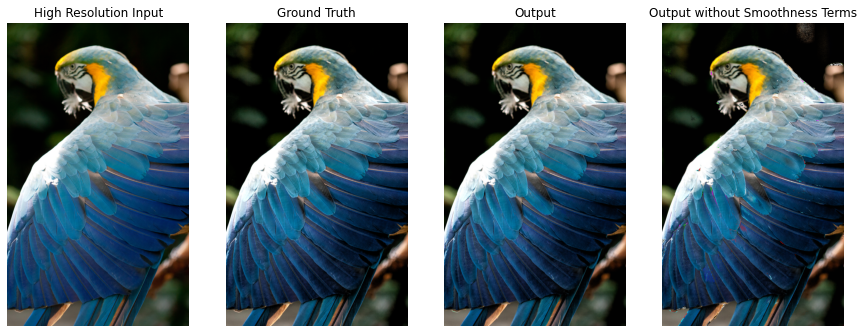

PSNR(without smoothness terms): 40.22 dB
SSIM(without smoothness terms): 0.92 dB
PSNR(with smoothness terms): 41.53 dB
SSIM(with smoothness terms): 0.96 dB


In [60]:
highr_input_image = io.imread(path.join('images','llf_high_in.png'))
lowr_input_image = io.imread(path.join('images','llf_low_in.png'))

highr_output_image = io.imread(path.join('images','llf_high_out.png'))
lowr_output_image = io.imread(path.join('images','llf_low_out.png'))
llf = []*8

llf = wrapper(
    lowr_input_image, highr_input_image, optGrad, 
    lowr_out =lowr_output_image, 
    highr_out =highr_output_image, 
    opt=False)

savePlots('llf', llf)

## Test on Gradient Enhancement Operator

cholesky  time: 83.7018506526947
cholesky  time: 0.057669639587402344


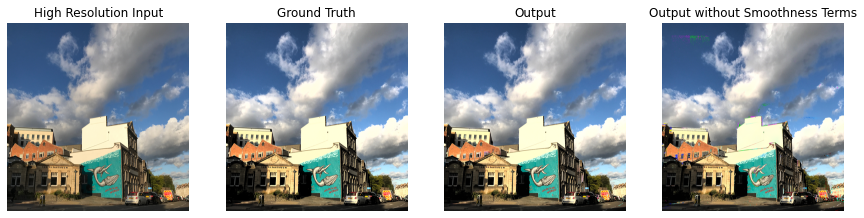

PSNR(without smoothness terms): 40.66 dB
SSIM(without smoothness terms): 0.95 dB
PSNR(with smoothness terms): 41.21 dB
SSIM(with smoothness terms): 0.99 dB


In [61]:
highr_input_image = io.imread(path.join('images','geo_high_in.jpg'))
lowr_input_image = io.imread(path.join('images','geo_low_in.jpg'))
geo = []*8
geo = wrapper(lowr_input_image, highr_input_image, optGrad)

savePlots('geo', geo)

## Tone Mapping

In [68]:
# for storing the original pairs and the resultant pairs TMQI
tmqi = np.zeros((4,2,3)) #algorithm used, input or output pairs, the three index Q,S,N

Original High Resolution Pairs
TMQI 
 Q: 0.21171588,        S: 0.01266107,        N: 4.2891677590540357e-13

Original Low Resolution Pairs
TMQI 
 Q: 0.21103874,        S: 0.01252861,        N: 5.165075810370316e-12



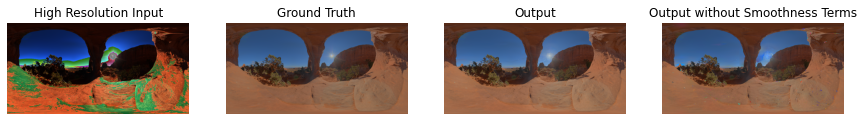

PSNR(without smoothness terms): 35.89 dB
SSIM(without smoothness terms): 0.95 dB
PSNR(with smoothness terms): 31.28 dB
SSIM(with smoothness terms): 0.97 dB
Resultant High Resolution Pairs
TMQI 
 Q: 0.2019154,        S: 0.01083661,        N: 6.668144274250728e-13



In [72]:
print('Original High Resolution Pairs')
highr_input_image, highr_output_image, tmqi[0,0,:] = prepareHDRimg(False,tm_td=True)
print('Original Low Resolution Pairs')
lowr_input_image, lowr_output_image,_ = prepareHDRimg(True, tm_td=True)

tm_td = []*8
tm_td = wrapper(lowr_input_image, highr_input_image, optGrad, 
              lowr_out =lowr_output_image, 
              highr_out =highr_output_image, 
              opt=False)

a = highr_input_image/255
b = tm_td[1]/255
print('Resultant High Resolution Pairs')
tmqi[0,1,:] = tm_index(a,b)

savePlots('tm_td', tm_td)

Original High Resolution Pairs
TMQI 
 Q: 0.21171588,        S: 0.01266107,        N: 4.2891677590540357e-13

Original Low Resolution Pairs
TMQI 
 Q: 0.21103874,        S: 0.01252861,        N: 5.165075810370316e-12



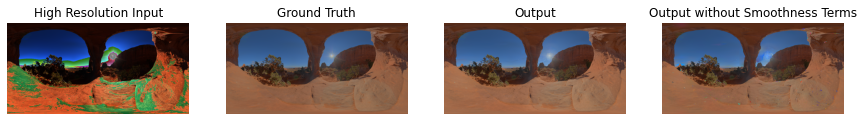

PSNR(without smoothness terms): 35.89 dB
SSIM(without smoothness terms): 0.95 dB
PSNR(with smoothness terms): 31.28 dB
SSIM(with smoothness terms): 0.97 dB
Resultant High Resolution Pairs
TMQI 
 Q: 0.2019154,        S: 0.01083661,        N: 6.668144274250728e-13



In [73]:
print('Original High Resolution Pairs')
highr_input_image, highr_output_image, tmqi[1,0,:] = prepareHDRimg(False,tm_r=True)
print('Original Low Resolution Pairs')
lowr_input_image, lowr_output_image,_ = prepareHDRimg(True, tm_r=True)

tm_r = []*8
tm_r = wrapper(lowr_input_image, highr_input_image, optGrad, 
              lowr_out =lowr_output_image, 
              highr_out =highr_output_image, 
              opt=False)

print('Resultant High Resolution Pairs')
a = highr_input_image/255
b = tm_r[1]/255
tmqi[1,1,:] = tm_index(a,b)

savePlots('tm_r', tm_r)

Original High Resolution Pairs
TMQI 
 Q: 0.21171588,        S: 0.01266107,        N: 4.2891677590540357e-13

Original Low Resolution Pairs
TMQI 
 Q: 0.21103874,        S: 0.01252861,        N: 5.165075810370316e-12



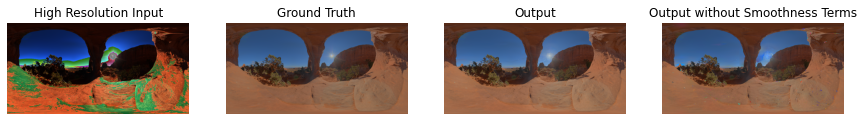

PSNR(without smoothness terms): 35.89 dB
SSIM(without smoothness terms): 0.95 dB
PSNR(with smoothness terms): 31.28 dB
SSIM(with smoothness terms): 0.97 dB
Resultant High Resolution Pairs
TMQI 
 Q: 0.2019154,        S: 0.01083661,        N: 6.668144274250728e-13



In [74]:
print('Original High Resolution Pairs')
highr_input_image, highr_output_image, tmqi[2,0,:] = prepareHDRimg(False,tm_m=True)
print('Original Low Resolution Pairs')
lowr_input_image, lowr_output_image,_ = prepareHDRimg(True, tm_m=True)

tm_m = []*8
tm_m = wrapper(lowr_input_image, highr_input_image, optGrad, 
              lowr_out =lowr_output_image, 
              highr_out =highr_output_image, 
              opt=False)

print('Resultant High Resolution Pairs')
a = highr_input_image/255
b = tm_m[1]/255
tmqi[2,1,:] = tm_index(a,b)

savePlots('tm_m', tm_m)

Original High Resolution Pairs
TMQI 
 Q: 0.21171588,        S: 0.01266107,        N: 4.2891677590540357e-13

Original Low Resolution Pairs
TMQI 
 Q: 0.21103874,        S: 0.01252861,        N: 5.165075810370316e-12



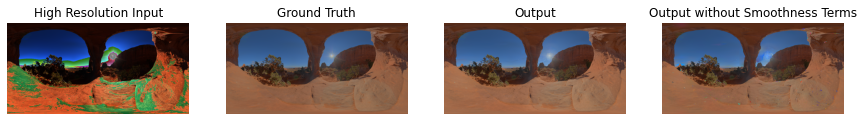

PSNR(without smoothness terms): 35.89 dB
SSIM(without smoothness terms): 0.95 dB
PSNR(with smoothness terms): 31.28 dB
SSIM(with smoothness terms): 0.97 dB
Resultant High Resolution Pairs
TMQI 
 Q: 0.2019154,        S: 0.01083661,        N: 6.668144274250728e-13



In [75]:
print('Original High Resolution Pairs')
highr_input_image, highr_output_image, tmqi[3,0,:] = prepareHDRimg(False,tm_tdu=True)
print('Original Low Resolution Pairs')
lowr_input_image, lowr_output_image,_ = prepareHDRimg(True, tm_tdu=True)

tm_tdu = []*8
tm_tdu = wrapper(lowr_input_image, highr_input_image, optGrad, 
              lowr_out =lowr_output_image, 
              highr_out =highr_output_image, 
              opt=False)

print('Resultant High Resolution Pairs')
a = highr_input_image/255
b = tm_tdu[1]/255
tmqi[3,1,:] = tm_index(a,b)

savePlots('tm_tdu', tm_tdu)

## Impact of mapping affine model with blurred images

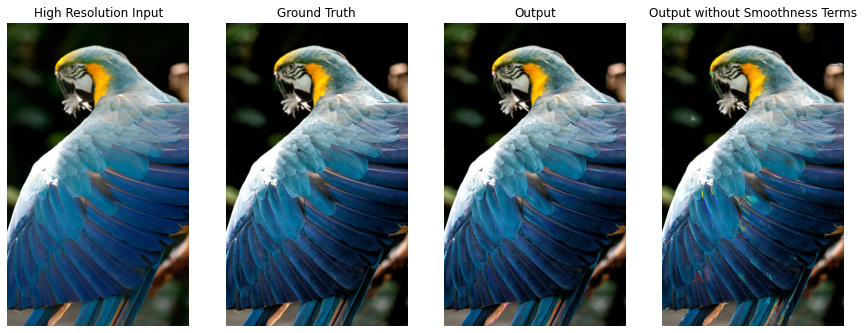

PSNR(without smoothness terms): 39.18 dB
SSIM(without smoothness terms): 0.89 dB
PSNR(with smoothness terms): 39.88 dB
SSIM(with smoothness terms): 0.94 dB


In [117]:
highr_input_image = io.imread(path.join('images','llf_high_in.png'))
lowr_input_image = io.imread(path.join('images','llf_low_in.png'))

highr_output_image = io.imread(path.join('images','llf_high_out.png'))
lowr_output_image = io.imread(path.join('images', 'llf_low_out.png'))

llf_gau = []*8
llf_gau = wrapper(lowr_input_image, highr_input_image, optGrad, lowr_out = lowr_output_image, highr_out = highr_output_image, gaussian = True, opt=False)

savePlots('llf_gau', llf_gau)

## Impact of using nearest neighbour instead of linear interpolations

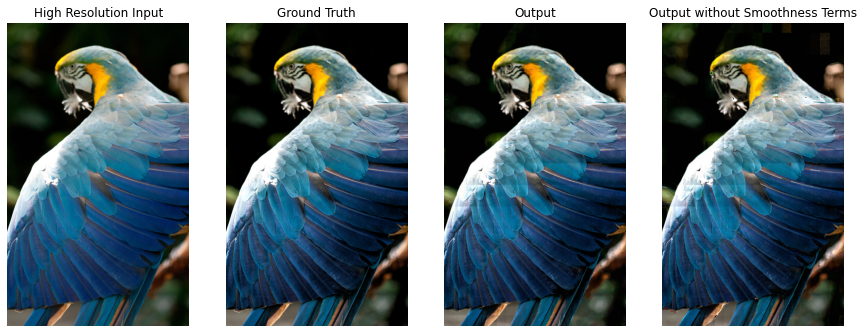

PSNR(without smoothness terms): 33.9 dB
SSIM(without smoothness terms): 0.86 dB
PSNR(with smoothness terms): 32.72 dB
SSIM(with smoothness terms): 0.87 dB


In [118]:
highr_input_image = io.imread(path.join('images','llf_high_in.png'))
lowr_input_image = io.imread(path.join('images','llf_low_in.png'))

highr_output_image = io.imread(path.join('images','llf_high_out.png'))
lowr_output_image = io.imread(path.join('images', 'llf_low_out.png'))

llf_near = []*8
llf_near = wrapper(
    lowr_input_image, highr_input_image, optGrad, 
    lowr_out = lowr_output_image, highr_out = highr_output_image, 
    gaussian = False, opt=False, nearest=True)

savePlots('llf_near', llf_near)

## Report Plot 1

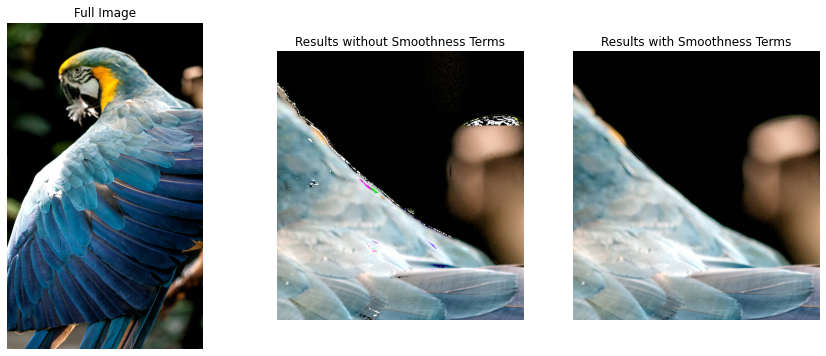

In [91]:
cropx0 = 200
cropx = 800
cropy = -550
plt.figure(figsize=(15, 6))
plt.subplot(131)
plt.title('Full Image')
plt.axis('off')
plt.imshow(llf[-2])

plt.subplot(132)
plt.title('Results without Smoothness Terms')
plt.axis('off')
plt.imshow(llf[0][cropx0:cropx, cropy:])

plt.subplot(133)
plt.title('Results with Smoothness Terms')
plt.axis('off')
plt.imshow(llf[1][cropx0:cropx, cropy:])

plt.savefig('./results/plots/f1.png')
plt.show()

## Report Plot 2

In [195]:
def printQSN(qsn, t):
    return "Q:"+ str(qsn[t,0,0]) + ", S:"+ str(qsn[t,0,1]) + ", N:"+ str(qsn[t,0,2])

/home/elim/anaconda3/envs/graphics/lib/python3.6/site-packages/ipykernel_launcher.py:35: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


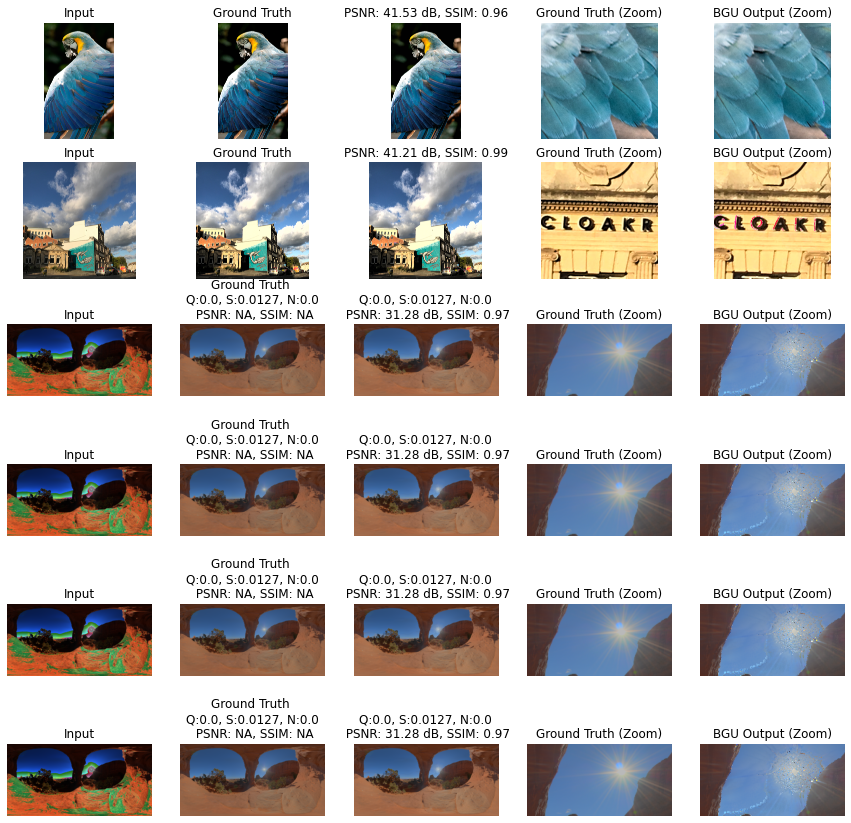

In [249]:
experiments = [llf, geo, tm_td, tm_r, tm_m, tm_tdu]
tmqi_r=tmqi
tmqi_r[:,:,:1] = np.round(tmqi[:,:,:1],2)
tmqi_r[:,:,2] = tmqi[:,:,2]


fig = plt.figure(figsize=(15,15))
widths = [1,1,1,1,1]
heights = [1,1,1,1,1,1]
# axes.axis('off')
spec = fig.add_gridspec(ncols=5, nrows=6, width_ratios=widths,
                          height_ratios=heights)

# axs[0, 0].set_title('Axis [0,0]')
# axs[0, 1].set_title('Axis [0,1]')
# axs[1, 0].set_title('Axis [1,0]')
# axs[1, 1].set_title('Axis [1,1]')

for i, arg in enumerate(experiments):
    r = i
    tm = i - 2
    crop = [[1000,1300,500,800],
            [2300,2500,700,900],
            [250,350,800,1000],
            [250,350,800,1000],
            [250,350,800,1000],
            [250,350,800,1000]
           ]
    
    ax1 = fig.add_subplot(spec[r,0])
    ax1.axis('off')
    ax1.set_title('Input')
    ax1.imshow(arg[-1])

    ax1 = fig.add_subplot(spec[r,0])
    ax1.axis('off')
    ax1.imshow(arg[-1])

    ax2 = fig.add_subplot(spec[r,1])
    if tm>= 0:
        tx= 'Ground Truth \n' + printQSN(tmqi_r, tm) + '\n PSNR: NA, SSIM: NA'
    else:
        tx ='Ground Truth'
    ax2.set_title(tx)
    ax2.axis('off')
    ax2.imshow(arg[-2])

    ax3 = fig.add_subplot(spec[r,2])
    if tm>= 0:
        tx = printQSN(tmqi_r, tm) + "\n PSNR: " + str(np.round(arg[3],2)) + " dB, SSIM: " + str(np.round(arg[5],2))
    else:
        tx = "PSNR: " + str(np.round(arg[3],2)) + " dB, SSIM: " + str(np.round(arg[5],2))
    ax3.set_title(tx)
    ax3.axis('off')
    ax3.imshow(arg[1])

    ax4 = fig.add_subplot(spec[r,3])
    ax4.set_title('Ground Truth (Zoom)')
    ax4.axis('off')
    ax4.imshow(arg[-2][crop[i][0]:crop[i][1], crop[i][2]:crop[i][3]])

    ax5 =fig.add_subplot(spec[r,4])
    ax5.set_title('BGU Output (Zoom)')
    ax5.axis('off')
    ax5.imshow(arg[1][crop[i][0]:crop[i][1], crop[i][2]:crop[i][3]])


# plt.savefig('./results/plots/f2.png')
plt.show()
